# Quantifying the Spatial Drivers of On-Field Reaction Time
#### Vaughn Hajra, 12/24/2025

The modular setup of this notebook is designed for easy integration of new methods and models. This is done with the goal of open-source use, providing clear entry points for feature extension. For more information on open-source contributions, see `CONTRIBUTING.md`.

#### Submission Notebook Contents:
1. **Setup:** Imports packages and defines matches.<br><br>
2. **Data Processing:** Loads raw data and produces model-ready dataframes.<br><br>
3. **Exploratory Statistical Tests:** Tests **defensive response latency** for normality, homogeneity of variance, and heterogeneity across players.<br><br>
4. **Ordinary Least Squares Regression:** Baseline model chosen for easy interpretation, also checks for multicollinearity.<br><br>
5. **Random Forest:** Model chosen to capture nonlinear interactions and higher-order effects.<br><br>
6. **OLS Regression and Random Forest Summary Table:** Custom table to summarize model findings.<br><br>
7. **Gaussian Mixture Model Setup & Clustering:** Applies a soft clustering technique to generate unique player response profiles.<br><br>

### 1. Setup

First, make sure everything is ready to run. This means import libraries, enable auto-reload (so changes will automatically track when contributing to the src folder), define match IDs to load, and define a random seed so results can be re-produced.

In [1]:
# Optionally enable autoreload so changes are picked up when contributing
# %load_ext autoreload
# %autoreload 2

# Standard Libraries & General Utilities
import sys                                          # Access system-specific parameters
import os                                           # File path and OS interactions
import pandas as pd                                 # Data manipulation and DataFrames
import numpy as np                                  # Numerical operations and math
from IPython.display import HTML, display           # Formatted HTML display in notebook

# Ensure the root folder can always be found
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.abspath('.'))

# Local Project Modules (Custom functions from src/)
from src.data_loader import load_match_data         # Load raw match datasets
from src.kinematics import (
    compute_all_kinematics, 
    find_passes_by_events, 
    calculate_player_distance
)                                                   # Calculate movement-based features
from src.feature_engineering import (
    add_player_ball_features, 
    add_model_features, 
    detect_player_responses, 
    process_match_pipeline
)                                                   # Transformation and modeling pipelines

# Data Visualization
import matplotlib.pyplot as plt                     # Core plotting library

# Scientific & Statistical Analysis
from scipy import stats                             # Statistical tests (Levene, Shapiro-Wilk)
import statsmodels.api as sm                        # Statistical models and VIF calculation
from statsmodels.formula.api import ols             # R-style formulas for OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor # Check multicollinearity

# Machine Learning & Modeling (Scikit-Learn)
from sklearn.model_selection import train_test_split # Split data into train/test sets
from sklearn.preprocessing import StandardScaler      # Feature scaling and normalization
from sklearn.linear_model import LinearRegression     # Baseline OLS regression
from sklearn.ensemble import RandomForestRegressor    # Non-linear ensemble modeling
from sklearn.mixture import GaussianMixture           # Soft-clustering for player profiles
from sklearn.metrics import mean_squared_error, r2_score # Model performance evaluation
from sklearn.tree import plot_tree                    # Visualizing decision tree logic

# Match IDs to Process for analysis (can add or remove as needed)
match_ids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

# Choose a number for random seed (for replicability)
set_seed_number = 42

### 2. Data Processing

Now load the data, and create dataframes storing everything needed for modeling in subsequent sections. Also split the data up into categorical/continuous, train/test split dataframes for later use.

In [2]:
# This will hold dataframes from eacth match for model-ready data and player response frequency data
all_model_dfs = []
all_frequencies = []

# Main data import loop
for m_id in match_ids:
    try:
        m_df, f_stats = process_match_pipeline(m_id, load_match_data, compute_all_kinematics, add_model_features)
        all_model_dfs.append(m_df)
        all_frequencies.append(f_stats)
    except Exception as e:
        print(f"Error in match {m_id}: {e}")

# Combine 
model_df = pd.concat(all_model_dfs, ignore_index=True)
frequency_df = pd.concat(all_frequencies, ignore_index=True)

Loading & processing match 1886347: Success
Loading & processing match 1899585: Success
Loading & processing match 1925299: Success
Loading & processing match 1953632: Success
Loading & processing match 1996435: Success
Loading & processing match 2006229: Success
Loading & processing match 2011166: Success
Loading & processing match 2013725: Success
Loading & processing match 2015213: Success
Loading & processing match 2017461: Success


In [3]:
# Target variable for regression
target = 'reaction_time_s'

# Continuous features
features_cont = [
    'player_s_t0', 'pass_avg_speed', 'pass_length', 'distance_to_passer', 
    'distance_pass_end_to_goal', 'player_facing_passer_angle', 
    'opponents_within_5m_t0', 'distance_to_proximal_receiver', 'is_last_defender'
]

# Categorical features
features_cat = ['player_id', 'match_id', 'pass_index']

# Define full sets for statistical tests
X_continuous = model_df[features_cont]
X_categorical = model_df[features_cat]

X = model_df[features_cont + features_cat]
y = model_df[target]

# Train/test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=set_seed_number)

scaler = StandardScaler()

# Scale continuous features while preserving DataFrame structure
X_cont_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features_cont]), columns=features_cont, index=X_train.index)
X_cont_test_scaled = pd.DataFrame(scaler.transform(X_test[features_cont]), columns=features_cont, index=X_test.index)

# Extract categorical sets for consistency with original output
X_cat_train = X_train[features_cat]
X_cat_test = X_test[features_cat]

print(f"Final observations: {len(y)}")

Final observations: 7885


### 3. Exploratory Statistical Tests

Before diving into modeling, test for homogeneity of variance, normality, and heterogeneity of response latency across players.

In [4]:
# Filter for players with >= 10 observations to ensure statistical validity
valid_pids = X_categorical['player_id'].value_counts()[lambda x: x >= 10].index
mask = X_categorical['player_id'].isin(valid_pids)

# Prepare arrays for Levene's test (testing homogeneity of variance)
groups = [y[mask][X_categorical[mask]['player_id'] == p] for p in valid_pids]
lev_stat, lev_p = stats.levene(*groups, center='median')

# Fit OLS to extract residuals for Shapiro-Wilk (testing normality)
model = ols('y ~ C(player_id)', data={'y': y[mask], 'player_id': X_categorical[mask]['player_id']}).fit()
sw_stat, sw_p = stats.shapiro(model.resid)

# Output results
print(f"Levene's Test:   Stat={lev_stat:.4f}, p={lev_p:.4f}")
print(f"Shapiro-Wilk:    Stat={sw_stat:.4f}, p={sw_p:.4f}")

Levene's Test:   Stat=0.9851, p=0.5359
Shapiro-Wilk:    Stat=0.9734, p=0.0000


/Users/vaughnhajra/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7862.
  res = hypotest_fun_out(*samples, **kwds)


In [5]:
# Filter players with >= 10 observations again for consistency
counts = X_categorical['player_id'].value_counts()
valid_pids = counts[counts >= 10].index
mask = X_categorical['player_id'].isin(valid_pids)

# Group data into arrays for Kruskal-Wallis
groups = [y[mask][X_categorical[mask]['player_id'] == p] for p in valid_pids]

# Execute Kruskal-Wallis H-test
h_stat, p_val = stats.kruskal(*groups)
print(f"Kruskal-Wallis H-Test: Stat={h_stat:.4f}, p={p_val:.4g}")

Kruskal-Wallis H-Test: Stat=169.4306, p=0.1096


### 4. Ordinary Least Squares (OLS) Regression

Create an OLS model, to get a baseline interpretation of how various spatial features affect response latency. Also note that variance inflation factors are checked, with none showing concerns of multicollinearity.

In [6]:
# Perform OLS and print summary
X_ols_const = sm.add_constant(X_cont_train_scaled, has_constant='add')
model_ols = sm.OLS(y_train, X_ols_const)
results_ols = model_ols.fit()
print(results_ols.summary())

# Calculating R-squared: prepare test features by adding the constant term
X_test_ols_const = sm.add_constant(X_cont_test_scaled, has_constant='add')

# Get predictions for both sets
y_train_pred_ols = results_ols.predict(X_ols_const)
y_test_pred_ols = results_ols.predict(X_test_ols_const)

# Calculate R-squared scores
r2_train_ols = r2_score(y_train, y_train_pred_ols)
r2_test_ols = r2_score(y_test, y_test_pred_ols)

print(f"OLS Training R2: {r2_train_ols:.4f}")
print(f"OLS Test R2: {r2_test_ols:.4f}")

                            OLS Regression Results                            
Dep. Variable:        reaction_time_s   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     53.45
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           3.16e-94
Time:                        00:21:24   Log-Likelihood:                -448.30
No. Observations:                6308   AIC:                             916.6
Df Residuals:                    6298   BIC:                             984.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [7]:
# Add constant for intercept and calculate VIF for each feature
X_vif_df = sm.add_constant(X_continuous)
vif_series = pd.Series(
    [variance_inflation_factor(X_vif_df.values, i) for i in range(X_vif_df.shape[1])], 
    index=X_vif_df.columns
)

# Filter constant and sort results
vif_results = vif_series.drop('const').sort_values(ascending=False)

print("Variance Inflation Factors (VIF):")
print(vif_results.to_string())

# Note: VIF > 5-10 suggests high multicollinearity.

Variance Inflation Factors (VIF):
pass_length                      1.721472
pass_avg_speed                   1.622777
distance_to_proximal_receiver    1.376007
player_s_t0                      1.141523
distance_to_passer               1.088948
opponents_within_5m_t0           1.083646
distance_pass_end_to_goal        1.081884
is_last_defender                 1.059076
player_facing_passer_angle       1.004170


### 5. Random Forest

Next create a random forest with regularization. Also calculate feature importance and display the first tree in the forest as an example of structure.

RF Training R-squared: 0.2176
RF Test R-squared: 0.1263


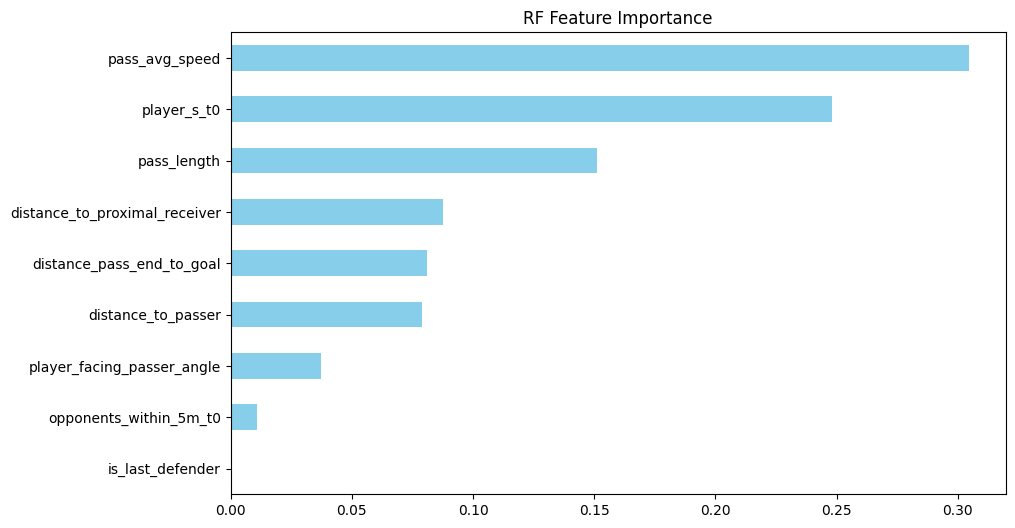

In [14]:
# Fit Random forest with regularization
rf = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=20, 
    max_features='sqrt', 
    random_state=set_seed_number
)
rf.fit(X_cont_train_scaled, y_train)

# Calculate Feature Importance
importances = pd.Series(rf.feature_importances_, index=X_cont_train_scaled.columns).sort_values(ascending=False)
# print("Feature Importances:\n", importances) # Commented out for submission, but if you want raw values you can see here


# Get predictions for R-squared
y_train_pred = rf.predict(X_cont_train_scaled)
y_test_pred = rf.predict(X_cont_test_scaled)

# Calculate and display R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"RF Training R-squared: {r2_train:.4f}")
print(f"RF Test R-squared: {r2_test:.4f}")

# Plot feature importance
importances.sort_values().plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title("RF Feature Importance")
plt.show()

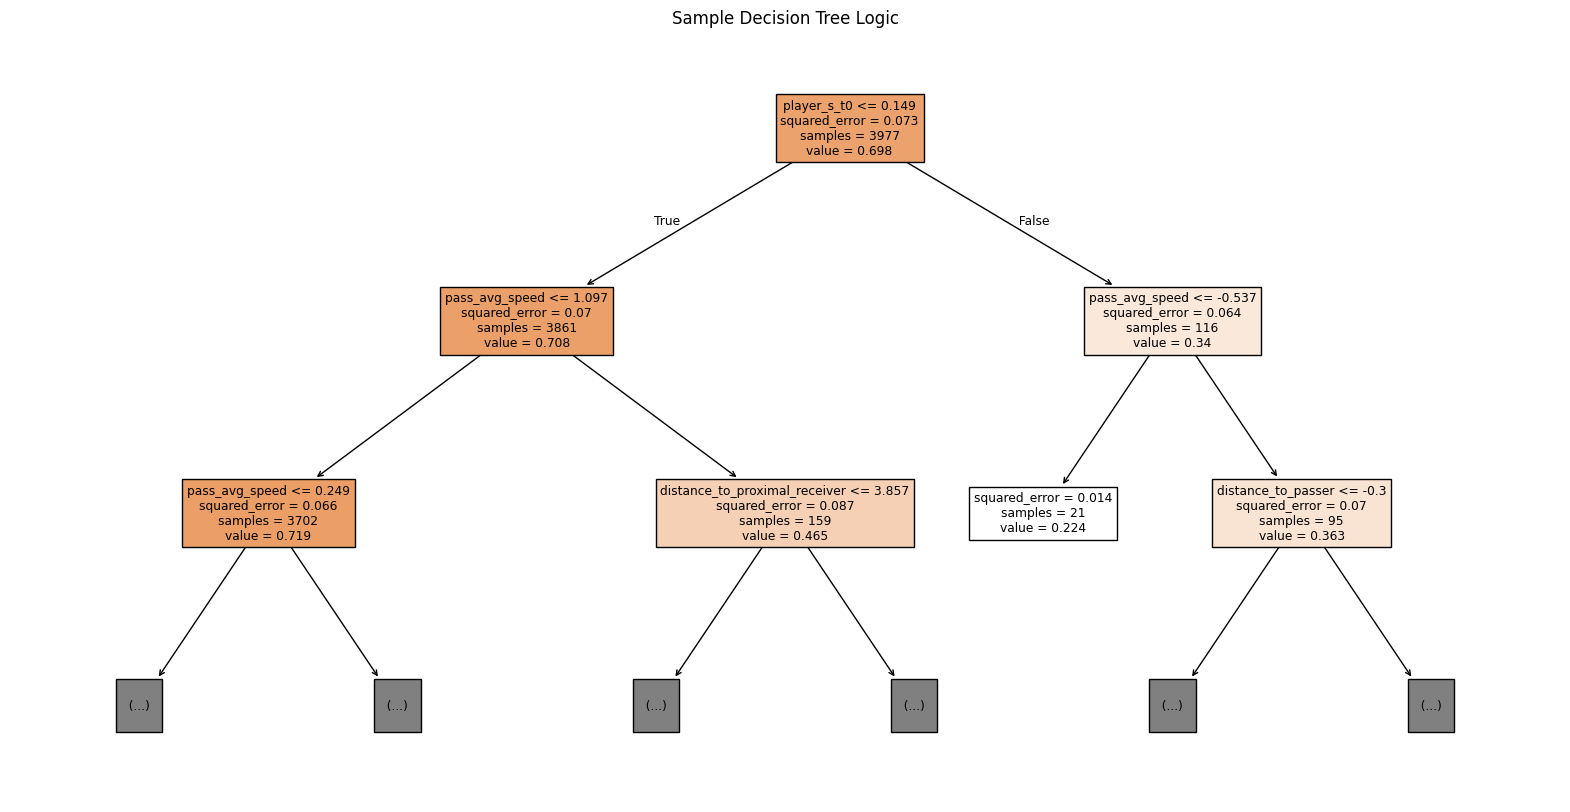

In [9]:
# Visualize first tree (limited depth for clarity)
plt.figure(figsize=(20, 10))
plot_tree(
    rf.estimators_[0], 
    feature_names=X_cont_train_scaled.columns, 
    filled=True, 
    max_depth=2
)
plt.title("Sample Decision Tree Logic")
plt.show()

### 6. OLS Regression and Random Forest Summary Table

This section creates a custom table with results from OLS regression and the Random Forest. It is hard-coded, so when contributing and adding new features, be sure to update the numbers here. The custom format is also chosen so more unique columns and notes can be added.

In [10]:
# Structured Data with updated OLS, VIF, and RF results
data = [
    ["(Intercept)", "0.6970***", "", ""],
    ["", "(0.003)", "", ""],
    ["Average Pass Speed", "-0.0538***", "1.62", "0.3045"],
    ["", "(0.004)", "", ""],
    ["Player Speed at t=0", "-0.0269***", "1.14", "0.2482"],
    ["", "(0.003)", "", ""],
    ["Pass Length", "0.0123***", "1.72", "0.1510"],
    ["", "(0.004)", "", ""],
    ["Distance: Pass End to Goal", "-0.0217***", "1.08", "0.0811"],
    ["", "(0.003)", "", ""],
    ["Distance to Passer", "-0.0084**", "1.09", "0.0787"],
    ["", "(0.003)", "", ""],
    ["Distance to Receiver", "-0.0150***", "1.38", "0.0878"],
    ["", "(0.004)", "", ""],
    ["Angle to Pass", "0.0048", "1.00", "0.0374"],
    ["", "(0.003)", "", ""],
    ["Opponents within 5m", "-0.0094***", "1.08", "0.0108"],
    ["", "(0.003)", "", ""],
    ["Is Last Defender", "-0.0072**", "1.06", "0.0005"],
    ["", "(0.003)", "", ""],
]

df = pd.DataFrame(data, columns=[
    'Variable', 
    'Ordinary Least Squares (OLS) Coefficient', 
    'Variance Inflation Factor (VIF)', 
    'Random Forest (RF) Importance'
])

# CSS Styles
styles = [
    dict(selector="th", props=[
        ("text-align", "center"), ("border-bottom", "2px solid black"), 
        ("padding", "10px 45px"), ("font-weight", "bold"), ("background-color", "white")
    ]),
    dict(selector="th:first-child", props=[("text-align", "left")]),
    dict(selector="td", props=[
        ("text-align", "center"), ("padding", "1px 45px"), ("border", "none")
    ]),
    dict(selector="td:first-child", props=[("text-align", "left"), ("min-width", "250px")]),
    dict(selector="tr:nth-child(even) td", props=[
        ("color", "#666"), ("font-size", "0.92em"), ("padding-bottom", "12px")
    ]),
    dict(selector="tr", props=[("background-color", "white")]),
    dict(selector="tbody", props=[("border-bottom", "2px solid black")]),
    dict(selector="table", props=[("border-collapse", "collapse"), ("margin-bottom", "0px")])
]

# Render Title, Table, and Footnote with updated bottom-right stats
display(HTML("<h3 style='text-align:left; margin-bottom:15px; font-family: sans-serif;'>"
             "<strong>Figure 1:</strong> OLS Results, Variance Inflation Factors, and Random Forest Feature Importance</h3>"))

display(df.style.set_table_styles(styles).hide(axis='index'))

footer_html = f"""
<div style='width:100%; font-family: sans-serif; font-size: 12px; line-height: 1.6; margin-top: 15px; display: flex; justify-content: space-between;'>
    <div style='flex: 1;'>
        <strong>Notes:</strong>
        <ul style='margin: 5px 0 0 15px; padding: 0;'>
            <li>All input features are scaled; interpretation is based on standard deviations.</li>
            <li>Standard errors are reported in parentheses below OLS coefficients.</li>
            <li>Significance levels: *p < 0.1; **p < 0.05; ***p < 0.01.</li>
        </ul>
    </div>
    <div style='flex: 0 0 auto; text-align: right;'>
        <ul style='list-style-type: none; margin: 25px 0 0 0; padding: 0;'>
            <li>7,885 Observations (6,308 Train, 1,577 Test)</li>
            <li>OLS F-Statistic: 53.45 (p < 0.001)</li>
            <li>OLS Test R-Squared: 0.067</li>
            <li>RF Test R-Squared: 0.126</li>
        </ul>
    </div>
</div>
"""
display(HTML(footer_html))

Variable,Ordinary Least Squares (OLS) Coefficient,Variance Inflation Factor (VIF),Random Forest (RF) Importance
(Intercept),0.6970***,,
,(0.003),,
Average Pass Speed,-0.0538***,1.62,0.3045
,(0.004),,
Player Speed at t=0,-0.0269***,1.14,0.2482
,(0.003),,
Pass Length,0.0123***,1.72,0.1510
,(0.004),,
Distance: Pass End to Goal,-0.0217***,1.08,0.0811
,(0.003),,


### 7. Gaussian Mixture Model Setup & Clustering

This section summarizes creates a new dataframe for clustering, and uses a Gaussian Mixture Model to create 'soft' clusters. It also creates a unique cluster plot where the probability of being assigned to a cluster is assigned an RGB (or black) value, allowing the plot to showcase each player's unique mixture.

In [11]:
# Calculate average reaction time per player
player_avg_reaction = model_df.groupby('player_id')['reaction_time_s'].mean().reset_index()

# Rename the column for clarity
player_avg_reaction.rename(columns={'reaction_time_s': 'avg_reaction_time_s'}, inplace=True)

# Calculate average response frequency by player
# First, sum the totals for each player across all matches
player_avg_frequency = frequency_df.groupby('player_id')[['number_of_responses', 'possible_responses']].sum().reset_index()

# Calculate the overall frequency (Total Responses / Total Possible)
player_avg_frequency['avg_response_frequency'] = player_avg_frequency['number_of_responses'] / player_avg_frequency['possible_responses']

# Merge average frequency data onto the average reaction data
player_clustering_unscaled = player_avg_reaction.merge(
    player_avg_frequency, 
    on='player_id', 
    how='left'
)

player_clustering_unscaled = player_clustering_unscaled[
    player_clustering_unscaled['number_of_responses'] >= 50
].copy()

In [12]:
# Select the features for clustering
features = ['avg_reaction_time_s', 'avg_response_frequency']
X = player_clustering_unscaled[features].copy()

# Scale the data (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=set_seed_number, covariance_type='full')
gmm.fit(X_scaled)

probs = gmm.predict_proba(X_scaled)

# Assign the cluster labels back to original DataFrame (for future use)
player_clustering_unscaled['cluster'] = gmm.predict(X_scaled)

# Check the size of each cluster
print("Cluster Counts:")
print(player_clustering_unscaled['cluster'].value_counts())

# View the average stats per cluster to interpret them
cluster_summary = player_clustering_unscaled.groupby('cluster')[features].mean()
print("\nCluster Averages:")
print(cluster_summary)

Cluster Counts:
cluster
1    33
2    26
3    24
0     8
Name: count, dtype: int64

Cluster Averages:
         avg_reaction_time_s  avg_response_frequency
cluster                                             
0                   0.634397                0.170981
1                   0.684927                0.148088
2                   0.696001                0.215240
3                   0.738298                0.151323


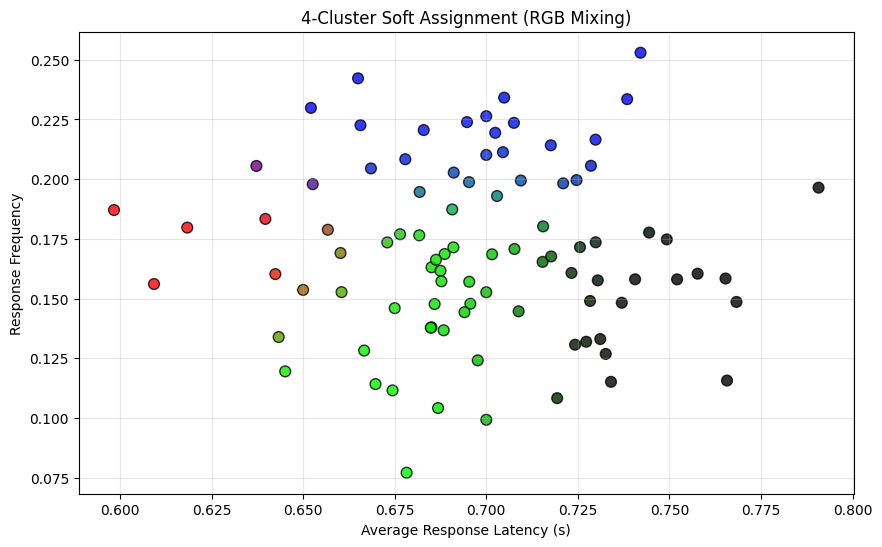

In [13]:
# Define colors for cluster plot
colors_base = np.array([
    [1, 0, 0], # Red
    [0, 1, 0], # Green
    [0, 0, 1], # Blue
    [0, 0, 0]  # Black
])

# Manually mix the colors: Multiply (N, 4) by (4, 3) to get (N, 3)
# This creates a weighted average color for every single point
mixed_colors = probs @ colors_base

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(
    x=player_clustering_unscaled['avg_reaction_time_s'], 
    y=player_clustering_unscaled['avg_response_frequency'], 
    c=mixed_colors, # Now exactly (N, 3) RGB
    s=60, 
    edgecolors='black', 
    alpha=0.8
)

plt.title('4-Cluster Soft Assignment (RGB Mixing)')
plt.xlabel('Average Response Latency (s)')
plt.ylabel('Response Frequency')
plt.grid(True, alpha=0.3)
plt.show()